C:\Users\Florin\AppData\Local\Temp\ipykernel_21572\2569196657.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean, cov, 1000)


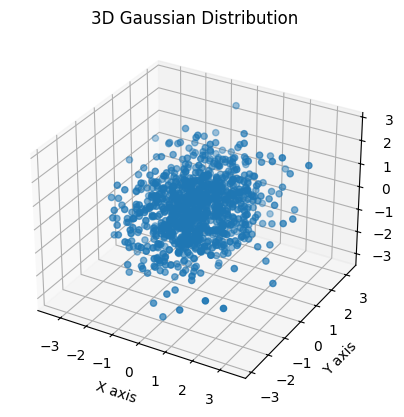

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the mean and covariance matrix
mean = [0, 0, 0]
cov = [[1, 0, 0.2], [0.1, 1, 0.1], [0.1, 0.2, 1]]  # Example covariance matrix

# Generate random samples
data = np.random.multivariate_normal(mean, cov, 1000)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2])

# Setting labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.title('3D Gaussian Distribution')
plt.show()


C:\Users\Florin\AppData\Local\Temp\ipykernel_21572\3690399954.py:9: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean, cov, 1000)


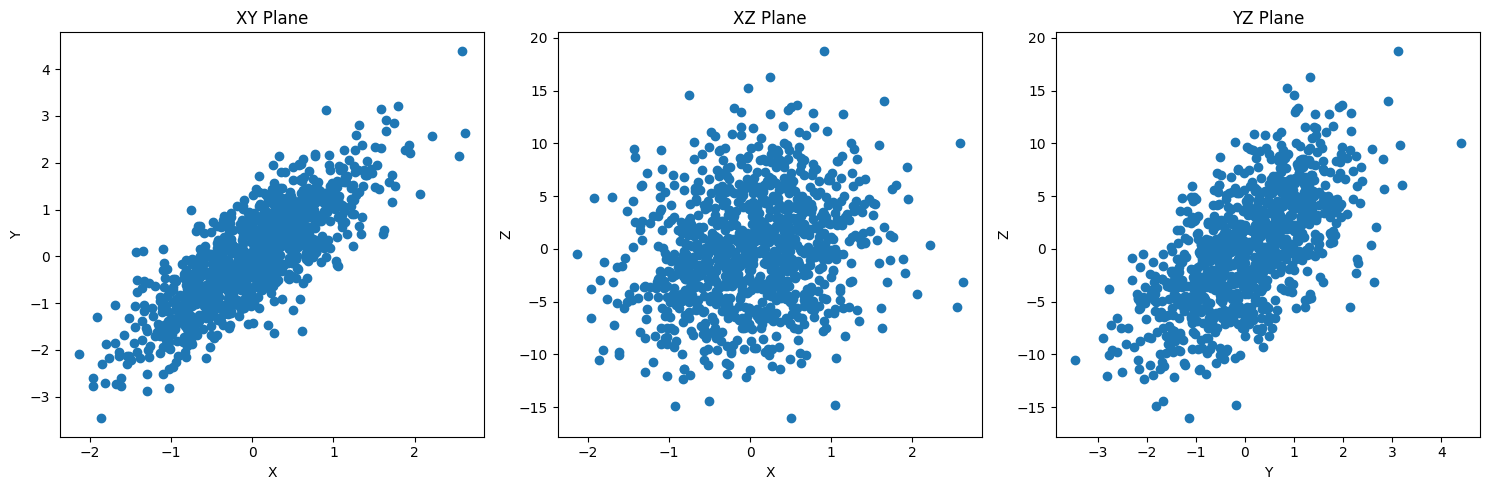

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Define the mean and covariance matrix (same as before)
mean = [0, 0, 0]
cov = [[1, 4, 30], [0.8, 1, 0.6], [0, 0, 1]]  # Example covariance matrix

# Generate random samples (same as before)
data = np.random.multivariate_normal(mean, cov, 1000)

# Plotting
fig = plt.figure(figsize=(15, 5))

# XY plane
ax1 = fig.add_subplot(131)  # 1 row, 3 cols, 1st subplot
ax1.scatter(data[:,0], data[:,1])
ax1.set_title('XY Plane')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# XZ plane
ax2 = fig.add_subplot(132)  # 1 row, 3 cols, 2nd subplot
ax2.scatter(data[:,0], data[:,2])
ax2.set_title('XZ Plane')
ax2.set_xlabel('X')
ax2.set_ylabel('Z')

# YZ plane
ax3 = fig.add_subplot(133)  # 1 row, 3 cols, 3rd subplot
ax3.scatter(data[:,1], data[:,2])
ax3.set_title('YZ Plane')
ax3.set_xlabel('Y')
ax3.set_ylabel('Z')

plt.tight_layout()
plt.show()


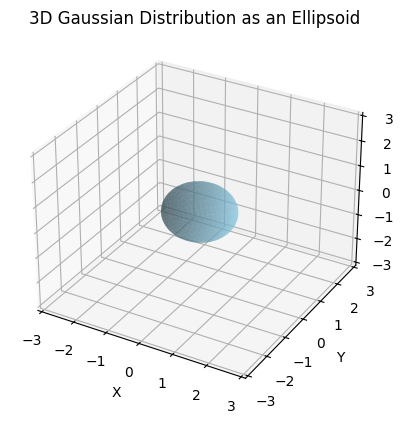

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def draw_ellipsoid(mean, cov, ax, n=100, color='b', alpha=0.2):
    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    # Get the radii of the ellipsoid
    radii = np.sqrt(eigenvalues)

    # Generate data for "unrotated" ellipsoid
    u = np.linspace(0, 2 * np.pi, n)
    v = np.linspace(0, np.pi, n)
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))

    # Rotate data with eigenvectors
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j], y[i,j], z[i,j]] = np.dot([x[i,j], y[i,j], z[i,j]], eigenvectors) + mean

    # Plot ellipsoid
    ax.plot_surface(x, y, z,  rstride=4, cstride=4, color=color, alpha=alpha)

# Mean and covariance matrix for the 3D Gaussian
mean = [0, 0, 0]
cov = [[1, 0.0, 0.0], [0.2, 1, 0.0], [0.1, 0.0, 1]]

# Set up the figure and axis for 3D plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Draw the ellipsoid
draw_ellipsoid(mean, cov, ax, color='skyblue', alpha=0.5)

# Labels and limits
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_zlim([-3, 3])
plt.title('3D Gaussian Distribution as an Ellipsoid')
plt.show()
